# Faces 3D

#### Scopo del progetto: Acquisire modelli 2.5 D di volti umani con tecnologie di fascia consumer
#### Strumentazione: Intel® RealSense™ Depth Camera D435, supporto rigido per 2 camere, cavalletto


## Intel® RealSense™ Depth Camera D435

![](camera.png)

#### Sistema Simple Stereo:
* Piani immagine coplanari
* Posizioni dei sistemi di riferimento delle camere note: displacement solo lungo asse X
* Parametri intrinseci delle camere note (lunghezza focale, posizione centro ottico)
* Matching tra immagine di sinistra e di destra avviene su scanlines orizzontali
* La depth (Z) è inversamente proporzionale alla disparità

<div width="100%" align="center">
<img src="SStereo.png" width="60%">
</div>

## Moduli della camera D435

<div width="100%" align="center">
<img src="modules.jpg" width="100%">
</div>

* I due sensori (camere) acquisiscono nell'infrarosso la scena effettuando poi il matching come qualsiasi sistema di acquisizione stereo
* Il matching viene ulteriormente migliorato utilizzando un proiettore IR: quest'ultimo proietta un pattern non casuale sulla scena che viene utilizzato per dare texture laddove non ci sia e come illuminante in assenza di luce naturale (che contiene anch'essa una componente IR).


#### Nota bene: La depth non viene ricostruita utilizzando un sensore basato su Time of flight, tenere quindi in considerazione le problematiche per l'esecuzione del matching tra le due immagini (left e right) relative a:
1. Illuminazione
2. Texture
3. Riflessi

# Esempio di acquisizione con/senza pattern IR

## Acquisizione di superfice priva di texture con proiettore IR spento
<div width="100%">
<img src="color_emitter_off.jpg" width="40%">
<img src="depth_emitter_off.png" width="40%">
</div>

<div width="100%">
<img src="emitter_off.png" width="100%">
</div>

## Acquisizione di superfice priva di texture con proiettore IR acceso
<div width="100%">
<img src="color_emitter_on.jpg" width="40%">
<img src="depth_emitter_on.png" width="40%">
</div>

<div width="100%">
<img src="emitter_on.png" width="100%">
</div>

# Point-cloud
È un insieme di punti nello spazio ognuno dei quali definiti nella loro posizione secondo gli assi X, Y, Z in un determinato sistema di coordinate e caratterizzati da eventuali valori di intensità (RGB o altre lunghezze scalari.) ad essi associati.

<div width="100%" align="center">
<img src="point_cloud.png" width="800px">
</div>

# Come costruire la point-cloud partendo dalla depth-map

Dato un valore di profondità $d$ in coordinate immagine $(u, v)$, il punto 3D corrispondente sarà: 

$z = d / depthScale$

$x = (u - c_x) * z / f_x$

$y = (v - c_y) * z / f_y$

<div width="100%" align="center">
<img src="depth_to_pointcloud.png" width="800px">
</div>

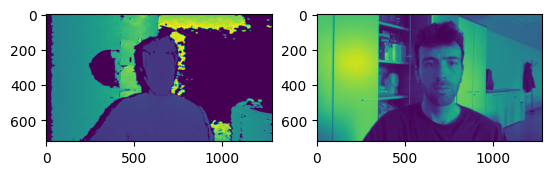

In [2]:
import math
import itertools
import open3d as o3d
import pyrealsense2 as rs
import matplotlib.pyplot as plt

intr = rs.pyrealsense2.intrinsics()
intr.width = 1280
intr.height= 720
intr.fx = 630.1680297851562
intr.fy = 630.1680297851562
intr.ppx = 637.7420654296875
intr.ppy = 352.65020751953125


depth = o3d.io.read_image("depth_not_aligned.png")
color = o3d.io.read_image("color_not_aligned.jpg")

rgbd_image = o3d.geometry.RGBDImage.create_from_color_and_depth(color, depth)

plt.subplot(1,2,1)
plt.imshow(rgbd_image.depth)
plt.subplot(1,2,2)
plt.imshow(rgbd_image.color)

camera_intrinsic = o3d.camera.PinholeCameraIntrinsic(o3d.camera.PinholeCameraIntrinsic(
    intr.width, intr.height, intr.fx, intr.fy, intr.ppx, intr.ppy
))

pcd = o3d.geometry.PointCloud.create_from_rgbd_image(rgbd_image, camera_intrinsic)
bounds = [[-math.inf, math.inf], [-math.inf, math.inf], [0.1, 1]]  # set the bounds
bounding_box_points = list(itertools.product(*bounds))  # create limit points
bounding_box = o3d.geometry.AxisAlignedBoundingBox.create_from_points(o3d.utility.Vector3dVector(bounding_box_points))  # create bounding box object
pcd = pcd.crop(bounding_box)


In [3]:
o3d.visualization.draw_geometries([pcd])

[Open3D WARNING] GLFW Error: WGL: Failed to make context current: L'operazione di trasformazione richiesta non è supportata. 


Anche avendo la stessa risoluzione (1280x720) nelle 2 camere IR e quella RGB, non troviamo corrispondenza pixel-by-pixel tra le due immagini.
Questo è dovuto al posizionamento fisico dei sensori (displacement tra rgb e IR) e ai differenti Field Of View dei sensori.
RealSense mette a disposizione un metodo che permette di allineare le due immagini (traslazione e scala).

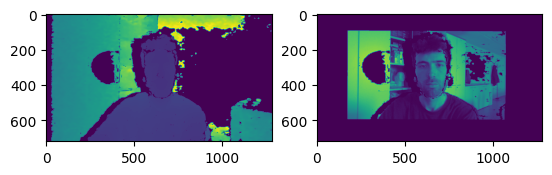

In [4]:
depth = o3d.io.read_image("depth_aligned.png")
color = o3d.io.read_image("color_aligned.jpg")

rgbd_image = o3d.geometry.RGBDImage.create_from_color_and_depth(color, depth)

plt.subplot(1,2,1)
plt.imshow(rgbd_image.depth)
plt.subplot(1,2,2)
plt.imshow(rgbd_image.color)

pcd = o3d.geometry.PointCloud.create_from_rgbd_image(rgbd_image, camera_intrinsic)
bounds = [[-math.inf, math.inf], [-math.inf, math.inf], [0.1, 1]]  # set the bounds
bounding_box_points = list(itertools.product(*bounds))  # create limit points
bounding_box = o3d.geometry.AxisAlignedBoundingBox.create_from_points(o3d.utility.Vector3dVector(bounding_box_points))  # create bounding box object
pcd = pcd.crop(bounding_box)

In [5]:
o3d.visualization.draw_geometries([pcd])

# Introduzione della seconda camera

### Perché una seconda camera?
Lo scopo è quello di raccogliere dettagli di una faccia 2.5D coprendo idealmente l'area compresa tra l'orecchio destro e sinistro.

## Setup di acquisizione

![](setup.jpg)

## I parametri
* Distanza delle due camere
* Rotazione delle due camere

Per raccogliere più dettagli possibili del volto dobbiamo far si che il volto da acquisire si trovi nell'intersezione dei due FOV delle camere.
Data una configurazione di distanza e rotazione, dobbiamo impostare una distanza del soggetto tale per cui esso ricada nell'intersezione dei due FOV.

<div>
<img src="ParametriSetup.png" width="500"/>
</div>

Vogliamo inoltre far si che la distanza del soggetto dalle camere sia minima per ottenere una risoluzione spaziale massima: se il soggetto cade nell'intersezione dei due FOV, ma risulta essere lontano, otterremo una risoluzione spaziale del volto (e di conseguenza dei dettagli) inferiore.

Dato che il goal del setup è anche di acquisire i dettagli dell'orecchio, il posizionamento delle due camere risulta essere cruciale perché più queste vengono allontanate e di conseguenza ruotate, più si perderanno dettagli frontali (come i particolari del naso). Per questo risulta magari utile pensare all'introduzione di una terza camera centrale.




# Acquisizione delle point-cloud

Ogni camera ricostruirà una point cloud, le quali verranno poi fuse seguendo una strategia predefinita. 

In base alla posizione relativa delle due camere, possiamo incorrere nelle seguenti situazioni:
* Camere (idealmente) sovrapposte: le point cloud corrisponderanno "perfettamente"
* Camere traslate: le point cloud saranno di conseguenza traslate 
* Camere traslate e ruotate: le point cloud saranno di consguenza traslate e ruotate

# Matrice di rototraslazione

Una generica matrice di rototraslazione è definita come segue:

<div width="100%" align="center">
<img src="traslazione.png" width='800px'>
</div>

### Componente di Traslazione

Prendendo come esempio due generiche point cloud, vediamo ora come definire una generica traslazione che permette di allineare una delle due point cloud sull'altra:

In [6]:
# SITUAZIONE INIZIALE -> Point cloud disallineate

import open3d as o3d
import numpy as np
pcl = o3d.geometry.PointCloud()
pcl.points = o3d.utility.Vector3dVector((np.random.randn(500,3)
))
pcl.paint_uniform_color((1,0,0))

traslazione = np.asarray([[1.0, 0.0, 0.0, 10.0],
                         [0.0, 1.0, 0.0, 0.0],
                         [0.0, 0.0, 1.0, 0.0],
                         [0.0, 0.0, 0.0, 1.0]])

transformed = o3d.geometry.PointCloud()
transformed.points = pcl.points
transformed.transform(traslazione)
transformed.paint_uniform_color((0,0,1))

o3d.visualization.draw_geometries([pcl, transformed])

In [7]:
# SITUAZIONE FINALE -> Dopo aver applicato la traslazione

## La traslazione è di -10.02 e non di -10 per scopo illustrativo (con sovrapposizione totale scomparirebbe una delle due point-cloud)
traslazione = np.asarray([[1.0, 0.0, 0.0, -10.02],
                         [0.0, 1.0, 0.0, 0.0],
                         [0.0, 0.0, 1.0, 0.0],
                         [0.0, 0.0, 0.0, 1.0]])
transformed.transform(traslazione)
o3d.visualization.draw_geometries([pcl, transformed])

Oltre alla traslazione, come nel nostro esempio, dovremmo intervenire sulla matrice $R$ di rotazione.
A questo scopo occorre sapere come costruirla opportunamente.


# Matrici di rotazione

In matematica, e in particolare in geometria, una rotazione è una trasformazione del piano o dello spazio euclideo che sposta gli oggetti in modo rigido rispetto ad una retta chiamata asse di rotazione (in genere un asse del sistema di riferimento), di un angolo $\theta$  


Per evitare ambiguità, si fissa una direzione dell'asse, e si considera la rotazione dell'angolo $\theta$ effettuata in senso antiorario rispetto all'asse orientato. 

Ad esempio per definire una rotazione nello spazio 3D rispetto all'asse Y di un sistema di riferimento ortonormale, è possibile utilizzare una matrice 3x3 così definita: 

$$ R=\begin{bmatrix} \cos{\theta} & 0 & -\sin{\theta} \\ 0 & 1 & 0 \\ \sin{\theta} & 0 & \cos{\theta} \end{bmatrix}$$

Ad ogni punto verrà quindi applicata la precedente rotazione:
$$ \begin{bmatrix} x' \\ y' \\ z' \end{bmatrix}=\begin{bmatrix} \cos{\theta} & 0 & -\sin{\theta} \\ 0 & 1 & 0 \\ \sin{\theta} & 0 & \cos{\theta} \end{bmatrix}\begin{bmatrix} x \\ y \\ z \end{bmatrix}$$



[0.         1.         1.41421356]


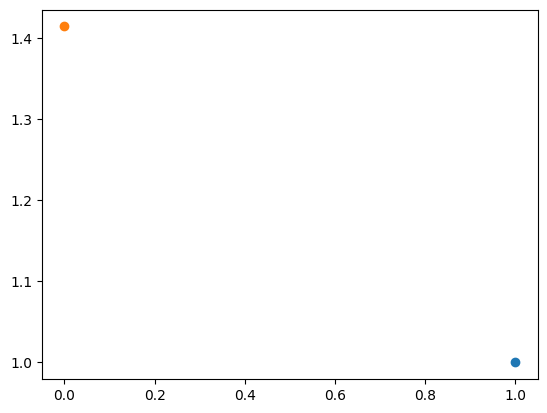

In [8]:
import matplotlib.pyplot as plt

point = [1,1,1]
angolo = np.pi/4
rotazione = np.asarray([ [np.cos(angolo), 0.0, -np.sin(angolo)],
                         [0.0, 1.0, 0.0],
                         [np.sin(angolo), 0.0, np.cos(angolo)]])

point_rot = rotazione.dot(point)
print(point_rot)

fig = plt.figure()
plt.scatter(point[0], point[2])
plt.scatter(point_rot[0], point_rot[2])


# Applicato ai nostri dati


Finora abbiamo parlato di rotazione e traslazione applicate ai punti della point-cloud, ma questo risulta essere correlato alla trasformazione che dobbiamo applicare al sistema di riferimento di una camera per allinearlo all'altro.
È necessario quindi stabilire quale delle due camere prendere come riferimento primario, nel nostro caso si è scelta quella di destra.


<div width="50%" align="center">
<img src="setupconassi.png" width="100%" style="position: relative">
</div>
<div width="50%" align="center">
<img src="setup.png"  width="100%" style="position: relative">
</div>

<div width="100%" align="center">
<img src="rototraslazioneSetup.png">
</div>

Possiamo notare come i due sistemi di riferimento differiscano di 30 gradi ruotando intorno all'asse y.
Avendo la camera destra come riferimento, considereremo come zero l'asse x della camera di destra e considerando come verso di rotazione convenzionale quello antiorario, possiamo stabilire che il sistema di riferimento della camera di sinistra è ruotato di -30° rispetto al sistema di riferimento primario.


<div width="100%" align="center">
<img src="nuovo.png">
</div>

Per capire meglio come è definita la trasformazione da applicare ai punti acquisiti dalla camera secondaria, è utile considerare il seguente esempio:

<div width="100%" align="center">
<img src="spiegazione_rototraslazione_ok.png">
</div>




# Traslazione e rotazione

In [9]:
from scipy.spatial.transform import Rotation   

def get_angles_from_transform_matrix(matrix):
    x = matrix[0][0:3]
    y = matrix[1][0:3]
    z = matrix[2][0:3]
    rotation_matrix = np.array([matrix[0][0:3],matrix[1][0:3],matrix[2][0:3]])
    t = [matrix[0][3], matrix[1][3], matrix[2][3]]
    r =  Rotation.from_matrix(rotation_matrix)
    angles = r.as_euler("xyz",degrees=True)
    print(f"R_x: {angles[0]:.3f}°  R_y: {angles[1]:.3f}°  R_z: {angles[2]:.3f}°")
    print(f"T_x: {t[0]:.3f}  T_y: {t[1]:.3f}  T_z: {t[2]:.3f}")

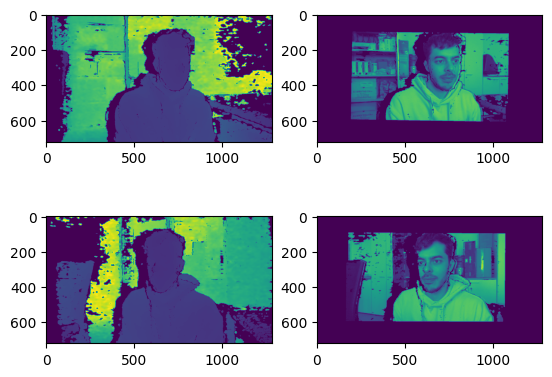

In [10]:
intr_left = rs.pyrealsense2.intrinsics()
intr_left.width = 1280
intr_left.height= 720
intr_left.fx = 642.353759765625
intr_left.fy = 642.353759765625
intr_left.ppx = 643.7830810546875
intr_left.ppy = 353.0009765625

intr_right = rs.pyrealsense2.intrinsics()
intr_right.width = 1280
intr_right.height= 720
intr_right.fx = 630.1680297851562
intr_right.fy = 630.1680297851562
intr_right.ppx = 637.7420654296875
intr_right.ppy = 352.65020751953125

camera_intrinsic_left = o3d.camera.PinholeCameraIntrinsic(o3d.camera.PinholeCameraIntrinsic(
    intr_left.width, intr_left.height, intr_left.fx, intr_left.fy, intr_left.ppx, intr_left.ppy
))
camera_intrinsic_right = o3d.camera.PinholeCameraIntrinsic(o3d.camera.PinholeCameraIntrinsic(
    intr_right.width, intr_right.height, intr_right.fx, intr_right.fy, intr_right.ppx, intr_right.ppy
))

depth_raw_left = o3d.io.read_image("d_full_ex_l.png")
color_raw_left = o3d.io.read_image("c_full_ex_l.jpg")

rgbd_image_left = o3d.geometry.RGBDImage.create_from_color_and_depth(color_raw_left, depth_raw_left)

depth_raw_right = o3d.io.read_image("d_full_ex_r.png")
color_raw_right = o3d.io.read_image("c_full_ex_r.jpg")

rgbd_image_right = o3d.geometry.RGBDImage.create_from_color_and_depth(color_raw_right, depth_raw_right)

plt.subplot(2,2,1)
plt.imshow(rgbd_image_left.depth)
plt.subplot(2,2,2)
plt.imshow(rgbd_image_left.color)
plt.subplot(2,2,3)
plt.imshow(rgbd_image_right.depth)
plt.subplot(2,2,4)
plt.imshow(rgbd_image_right.color)

In [14]:
pcd_left = o3d.geometry.PointCloud.create_from_rgbd_image(rgbd_image_left, camera_intrinsic_left)
pcd_right = o3d.geometry.PointCloud.create_from_rgbd_image(rgbd_image_right, camera_intrinsic_right)

bounds = [[-math.inf, math.inf], [-math.inf, math.inf], [0.1, 1]]  # set the bounds
bounding_box_points = list(itertools.product(*bounds))  # create limit points
bounding_box = o3d.geometry.AxisAlignedBoundingBox.create_from_points(o3d.utility.Vector3dVector(bounding_box_points))  # create bounding box object

# Crop the point cloud using the bounding box:
pcd_left = pcd_left.crop(bounding_box)
pcd_right = pcd_right.crop(bounding_box)

o3d.visualization.draw_geometries([pcd_left, pcd_right])

In [15]:
# Rotazione di 180° intorno all'asse X (ribaltare la point cloud poiché la pinhole camera ribalta la visuale)
angolo = np.pi
trans_x = np.asarray([   [1.0, 0.0, 0.0, 0.0],
                         [0.0, np.cos(angolo), -np.sin(angolo), 0.0],
                         [0.0, np.sin(angolo), np.cos(angolo), 0.0],
                         [0.0, 0.0, 0.0, 1.0]])

pcd_left.transform(trans_x)
pcd_right.transform(trans_x)

o3d.visualization.draw_geometries([pcd_left, pcd_right])

In [16]:
# Primario -> Camera di destra 
# Secondario -> Camera di sinistra

# Rotazione di -30° intorno all'asse Y
angolo = -np.pi/6
trans_y = np.asarray([[np.cos(angolo), 0.0, np.sin(angolo), -0.335],
                         [0.0, 1.0, 0.0, 0.0],
                         [-np.sin(angolo), 0.0, np.cos(angolo), 0.0],
                         [0.0, 0.0, 0.0, 1.0]])

pcd_left.transform(trans_y)


pcd_left.paint_uniform_color((1,0,0))  # LEFT BLU

pcd_right.paint_uniform_color((0,0,1)) # RIGHT ROSSO

o3d.visualization.draw_geometries([pcd_left, pcd_right])

[Open3D WARNING] GLFW Error: WGL: Failed to make context current: L'operazione di trasformazione richiesta non è supportata. 


# Come mai non c'è sovrapposizione perfetta?

<br/>
<br/>
<br/>
<br/>
<br/>

<br/>
<br/>
<br/>
<br/>
<br/><br/>
<br/>
<br/>
<br/>
<br/>

# Pausa di 15 minuti

<br/>
<br/>
<br/>
<br/>
<br/><br/>
<br/>
<br/>
<br/>
<br/>

# Come mai non c'è sovrapposizione perfetta?
La causa è da trovarsi nella scarsa precisione di posizionamento delle camere che porta ad avere parametri reali differenti da quelli teorici, e la conseguente matrice di rototraslazione. 
Per ovviare a questo problema è possibile utilizzare l'ICP (Iterative Closest Point), uno dei metodi di registrazione di point-cloud più utilizzati.

# ICP - Iterative Closest Point

<div>
<img src="icpgif.webp">
</div>

Problem Statement

* Si considera una point-cloud come modello
* Si considera poi una seconda point-cloud come scena, questa può anche non corrispondere esattamente al modello
* Il goal è di stimare la rototraslazione e scala ottimali che allineano la scena al modello

## Principali fondamenti dell'ICP

1. Si inizia con una rototraslazione e scala iniziale predefinite 

2. Si fissa il modello e si fa muovere la scena applicando la trasformazione definita al punto 1.
3. Si calcola l'errore (somma delle distanze tra le coppie di closest points) che rappresentano la dissimilarità della scena dal modello 
4. Se l'errore è minimo, la procedura termina (l'algoritmo garantisce la convergenza ma questo potrebbe essere un minimo locale e non globale)
5. Altrimenti, calcolare nuovi parametri di rototraslazione e scala per poi tornare al punto 2.

## Algoritmo

1. Initialize registration parameters (R,t,s) and registration error; Error = ∞

2. For each point in the scene shape, find the corresponding closest point in the model shape
3. Calculate registration parameters given point correspondences obtained from step 2.
4. Apply the alignment to the scene shape
5. Calculate the registration error between the currently aligned scene shape and the model shape
6. If error > threshold, return to step 2. , else return with new scene shape

<div>
<img src="icpesempio.png" width="50%">
</div>

Nota bene: l'inizializzazione è un punto cruciale per la buona riuscita della procedura, infatti più modello e scena sono distanti e/o differenti più sarà difficile per l'algoritmo stimare i parametri corretti ad ogni step. 
Nel nostro caso l'inizializzazione dei parametri di rototraslazione è ricavata dai parametri del setup di acquisizione.

In [17]:
# PER RICOSTRUZIONE OFFLINE

intr_left = rs.pyrealsense2.intrinsics()
intr_left.width = 1280
intr_left.height= 720
intr_left.fx = 642.353759765625
intr_left.fy = 642.353759765625
intr_left.ppx = 643.7830810546875
intr_left.ppy = 353.0009765625

intr_right = rs.pyrealsense2.intrinsics()
intr_right.width = 1280
intr_right.height= 720
intr_right.fx = 630.1680297851562
intr_right.fy = 630.1680297851562
intr_right.ppx = 637.7420654296875
intr_right.ppy = 352.65020751953125

camera_intrinsic_left = o3d.camera.PinholeCameraIntrinsic(o3d.camera.PinholeCameraIntrinsic(
    intr_left.width, intr_left.height, intr_left.fx, intr_left.fy, intr_left.ppx, intr_left.ppy
))
camera_intrinsic_right = o3d.camera.PinholeCameraIntrinsic(o3d.camera.PinholeCameraIntrinsic(
    intr_right.width, intr_right.height, intr_right.fx, intr_right.fy, intr_right.ppx, intr_right.ppy
))

depth_raw_left = o3d.io.read_image("d_full_ex_l.png")
color_raw_left = o3d.io.read_image("c_full_ex_l.jpg")

rgbd_image_left = o3d.geometry.RGBDImage.create_from_color_and_depth(color_raw_left, depth_raw_left)

depth_raw_right = o3d.io.read_image("d_full_ex_r.png")
color_raw_right = o3d.io.read_image("c_full_ex_r.jpg")

rgbd_image_right = o3d.geometry.RGBDImage.create_from_color_and_depth(color_raw_right, depth_raw_right)

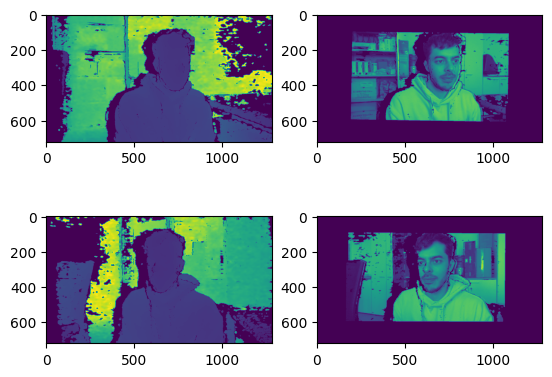

In [18]:
plt.subplot(2,2,1)
plt.imshow(rgbd_image_left.depth)
plt.subplot(2,2,2)
plt.imshow(rgbd_image_left.color)
plt.subplot(2,2,3)
plt.imshow(rgbd_image_right.depth)
plt.subplot(2,2,4)
plt.imshow(rgbd_image_right.color)

In [19]:
camera_intrinsic_left = o3d.camera.PinholeCameraIntrinsic(o3d.camera.PinholeCameraIntrinsic(
    intr_left.width, intr_left.height, intr_left.fx, intr_left.fy, intr_left.ppx, intr_left.ppy
))
camera_intrinsic_right = o3d.camera.PinholeCameraIntrinsic(o3d.camera.PinholeCameraIntrinsic(
    intr_right.width, intr_right.height, intr_right.fx, intr_right.fy, intr_right.ppx, intr_right.ppy
))
pcd_left = o3d.geometry.PointCloud.create_from_rgbd_image(rgbd_image_left, camera_intrinsic_left)
pcd_right = o3d.geometry.PointCloud.create_from_rgbd_image(rgbd_image_right, camera_intrinsic_right)

bounds = [[-math.inf, math.inf], [-math.inf, math.inf], [0.1, 0.6]]  # set the bounds
bounding_box_points = list(itertools.product(*bounds))  # create limit points
bounding_box = o3d.geometry.AxisAlignedBoundingBox.create_from_points(o3d.utility.Vector3dVector(bounding_box_points))  # create bounding box object

# Crop the point cloud using the bounding box:
pcd_left = pcd_left.crop(bounding_box)
pcd_right = pcd_right.crop(bounding_box)

angolo = np.pi
trans_x = np.asarray([   [1.0, 0.0, 0.0, 0.0],
                         [0.0, np.cos(angolo), -np.sin(angolo), 0.0],
                         [0.0, np.sin(angolo), np.cos(angolo), 0.0],
                         [0.0, 0.0, 0.0, 1.0]])

pcd_left.transform(trans_x)
pcd_right.transform(trans_x)

o3d.visualization.draw_geometries([pcd_left, pcd_right])

In [20]:
import copy

def draw_registration_result(source, target, transformation):
    source_temp = copy.deepcopy(source)
    target_temp = copy.deepcopy(target)
    source_temp.paint_uniform_color([1, 0., 0.2])
    target_temp.paint_uniform_color([0, 0.2, 1.0])
    source_temp.transform(transformation)
    o3d.visualization.draw_geometries([source_temp, target_temp])

In [21]:
angolo = -np.pi/6
source = pcd_left
target = pcd_right
trans_init = np.asarray([[np.cos(angolo), 0.0, np.sin(angolo), -0.335],
                         [0.0, 1.0, 0.0, 0.0],
                         [-np.sin(angolo), 0.0, np.cos(angolo), 0.0],
                         [0.0, 0.0, 0.0, 1.0]])
draw_registration_result(source, target, trans_init)

In [22]:
threshold = 0.02

print("Initial alignment")
evaluation = o3d.pipelines.registration.evaluate_registration(
    source, target, threshold, trans_init)
print(evaluation)

Initial alignment
RegistrationResult with fitness=1.280241e-02, inlier_rmse=1.106584e-02, and correspondence_set size of 2810
Access transformation to get result.


In [23]:
print("Apply point-to-point ICP")
reg_p2p = o3d.pipelines.registration.registration_icp(
    source, target, threshold, trans_init,
    o3d.pipelines.registration.TransformationEstimationPointToPoint(),
    o3d.pipelines.registration.ICPConvergenceCriteria(max_iteration=10000))
print(reg_p2p)
print("Transformation is:")
print(reg_p2p.transformation)
draw_registration_result(source, target, reg_p2p.transformation)

Apply point-to-point ICP
RegistrationResult with fitness=8.316370e-01, inlier_rmse=5.392811e-03, and correspondence_set size of 182536
Access transformation to get result.
Transformation is:
[[ 0.86063877 -0.01688127 -0.50893608 -0.3061189 ]
 [ 0.01829427  0.99983016 -0.00222748 -0.00464234]
 [ 0.50888724 -0.00739355  0.86080143 -0.07808197]
 [ 0.          0.          0.          1.        ]]


In [24]:
print("Trasformazione iniziale: ")
get_angles_from_transform_matrix(trans_y)

print("\n\nTrasformazione raffinata: ")
get_angles_from_transform_matrix(reg_p2p.transformation)

Trasformazione iniziale: 
R_x: 0.000°  R_y: -30.000°  R_z: 0.000°
T_x: -0.335  T_y: 0.000  T_z: 0.000


Trasformazione raffinata: 
R_x: -0.492°  R_y: -30.590°  R_z: 1.218°
T_x: -0.306  T_y: -0.005  T_z: -0.078


# Conclusioni

#### Dai risultati ottenuti possiamo vedere come i parametri teorici del setup siano effettivamente differenti rispetto a quelli stimati dall'ICP.

# Spunto per la calibrazione del sistema
Per calibrazione del sistema si intende la stima dei parametri reali del setup utilizzando l'ICP come visto precedentemente.
Si potrebbe pensare di calibrare il sistema utilizzando direttamente un volto (caratterizzato quindi da una superficie non rigida), ma questo potrebbe portare a problemi dati dal disallineamento temporale delle acquisizioni delle due camere, anche a questo problema in realtà esiste una soluzione data dal collegamento fisico dei clock delle due camere. 
Pensiamo quindi di calibrare il sistema utilizzando un oggetto rigido. 
Per l'ottima riuscita della calibrazione, occorre inoltre tenere in considerazione fattori relativi a:
* Segmentazione del solido di calibrazione
* Numero di punti in comune tra le due viste (acquisizioni)
* Forma dell'oggetto: l'ICP deve convergere verso l'unico ottimo (le due point-cloud devono incastrarsi in un solo modo)